# 🧠 CNN Classifier for Handwritten Hebrew Letters
This notebook implements a deep CNN to classify handwritten Hebrew letters using the HHD dataset.

**Experiments:**
- Training without data augmentation
- Training with data augmentation


## 📦 1. Imports and Setup

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## 🧼 2. Preprocessing Function
Define a function that normalizes and resizes input images to 32x32, including padding and inversion.

In [2]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    h, w = img.shape
    if h > w:
        pad = (h - w) // 2
        img = cv2.copyMakeBorder(img, 0, 0, pad, h - w - pad, cv2.BORDER_CONSTANT, value=255)
    elif w > h:
        pad = (w - h) // 2
        img = cv2.copyMakeBorder(img, pad, w - h - pad, 0, 0, cv2.BORDER_CONSTANT, value=255)
    img = cv2.resize(img, (32, 32))
    img = 255 - img
    return img.astype(np.float32) / 255.0

## 📥 3. Dataset Loader

In [3]:
from google.colab import files
files.upload()  # Upload hhd.zip

import zipfile

os.makedirs("hhd_dataset", exist_ok=True)

with zipfile.ZipFile("hhd.zip", 'r') as zip_ref:
    zip_ref.extractall("hhd_dataset")

def load_dataset(base_dir):
    X, y = load_dataset("hhd_dataset")
    for label in range(27):
        folder = os.path.join(base_dir, str(label))
        if not os.path.exists(folder): continue
        for fname in os.listdir(folder):
            img_path = os.path.join(folder, fname)
            img = preprocess_image(img_path)
            if img is not None:
                X.append(img.reshape(32, 32, 1))
                y.append(label)
    return np.array(X), np.array(y)

Saving hhd.zip to hhd.zip


In [4]:
for label in range(27):
    folder = os.path.join("hhd_dataset", str(label))
    for fname in os.listdir(folder):
        print(f"{label}/{fname}")
        break  # show just the first file in each folder


0/0_7.png
1/1_195.png
2/2_132.png
3/3_37.png
4/4_136.png
5/5_51.png
6/6_128.png
7/7_108.png
8/8_1.png
9/9_4.png
10/10_54.png
11/11_73.png
12/12_144.png
13/13_52.png
14/14_79.png
15/15_6.png
16/16_60.png
17/17_12.png
18/18_51.png
19/19_208.png
20/20_106.png
21/21_16.png
22/22_71.png
23/23_49.png
24/24_184.png
25/25_140.png
26/26_62.png


## 🔀 4. Load and Split Dataset

In [5]:
import shutil
from sklearn.model_selection import train_test_split

image_paths = []
labels = []

# Collect image paths and labels
for label in range(27):
    class_dir = os.path.join("hhd_dataset", str(label))
    if not os.path.exists(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(label)

# Split
X_temp, X_test, y_temp, y_test = train_test_split(image_paths, labels, test_size=0.1, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)

# Define save function
def save_split(X, y, folder):
    for path, label in zip(X, y):
        out_dir = os.path.join("processed_hhd", folder, str(label))
        os.makedirs(out_dir, exist_ok=True)
        shutil.copy(path, os.path.join(out_dir, os.path.basename(path)))

# Save to folders
save_split(X_train, y_train, "train")
save_split(X_val, y_val, "val")
save_split(X_test, y_test, "test")

# Define load dataset function
def load_dataset(base_dir):
    X, y = [], []
    for label in range(27):
        folder = os.path.join(base_dir, str(label))
        if not os.path.exists(folder):
            continue
        for fname in os.listdir(folder):
            img_path = os.path.join(folder, fname)
            img = preprocess_image(img_path)
            if img is not None:
                X.append(img.reshape(32, 32, 1))
                y.append(label)
    return np.array(X), np.array(y)

# Load images for CNN
X_train, y_train = load_dataset("processed_hhd/train")
X_val, y_val     = load_dataset("processed_hhd/val")
X_test, y_test   = load_dataset("processed_hhd/test")

## 🧠 5. CNN Model Architecture
Here we define a deep convolutional neural network with three repeated blocks, followed by dense layers.

In [17]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_cnn():
    model = Sequential()

    # First block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Second block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Dense layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(27, activation='softmax'))

    # Compile with a lower learning rate
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

## 🚂 6. Train CNN (No Augmentation)
Train the model on the dataset without any artificial modifications to the training images.

In [19]:
model = build_cnn()
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 45s 149ms/step - accuracy: 0.2067 - loss: 3.3040 - val_accuracy: 0.0850 - val_loss: 4.3259
Epoch 2/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 40s 147ms/step - accuracy: 0.5486 - loss: 1.5827 - val_accuracy: 0.3893 - val_loss: 2.2289
Epoch 3/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 39s 139ms/step - accuracy: 0.6614 - loss: 1.1466 - val_accuracy: 0.7628 - val_loss: 0.8201
Epoch 4/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.7017 - loss: 1.0197 - val_accuracy: 0.7787 - val_loss: 0.6587
Epoch 5/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.7375 - loss: 0.8537 - val_accuracy: 0.7945 - val_loss: 0.6137
Epoch 6/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.7706 - loss: 0.7491 - val_accuracy: 0.8320 - val_loss: 0.5564
Epoch 7/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - accuracy: 0.7964 - loss: 0.6986 - val_accuracy: 0.8300 - val_loss: 0.5603
Epoch 8/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 43s 142ms/step - accuracy: 0.7951 - loss: 0

## 🚀 7. Train CNN (With Augmentation)
Train the CNN model using image data augmentation to improve generalization and robustness.

The following augmentations are applied using ImageDataGenerator from Keras:
*   Width shift (width_shift_range=0.1): Randomly shifts the image horizontally by up to 10% of the width.

*   Height shift (height_shift_range=0.1): Randomly shifts the image vertically by up to 10% of the height.

*   Rotation (rotation_range=5): Randomly rotates the image by up to ±10 degrees.

*   Shear (shear_range=0.1): Applies random shear transformations (distorting image diagonally).

*   Brightness adjustment (brightness_range=(0.8, 1.2)): Randomly adjusts the brightness of the image to simulate different lighting conditions.

These augmentations are applied on-the-fly during training, so each epoch sees slightly different versions of the same input data. This helps the model generalize better to new, unseen handwriting styles.



X_train shape: (4044, 32, 32, 1), Range: [0.0, 1.0]
X_val shape: (506, 32, 32, 1), Range: [0.0, 1.0]
X_test shape: (506, 32, 32, 1), Range: [0.0, 1.0]
y_train shape: (4044,), Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
Number of samples per class in training:
Class 0: 155 samples
Class 1: 155 samples
Class 2: 155 samples
Class 3: 155 samples
Class 4: 155 samples
Class 5: 155 samples
Class 6: 155 samples
Class 7: 155 samples
Class 8: 155 samples
Class 9: 155 samples
Class 10: 155 samples
Class 11: 121 samples
Class 12: 159 samples
Class 13: 155 samples
Class 14: 129 samples
Class 15: 152 samples
Class 16: 132 samples
Class 17: 155 samples
Class 18: 144 samples
Class 19: 155 samples
Class 20: 124 samples
Class 21: 151 samples
Class 22: 135 samples
Class 23: 156 samples
Class 24: 170 samples
Class 25: 154 samples
Class 26: 147 samples


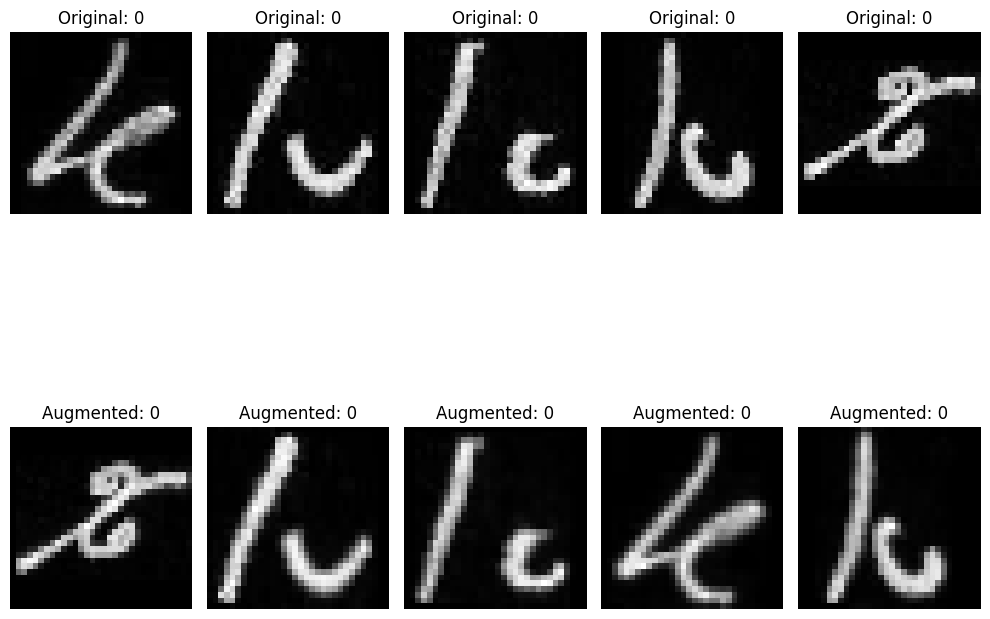

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training with fixed augmentation...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


253/253 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.2001 - loss: 3.3025 - val_accuracy: 0.0593 - val_loss: 4.8586 - learning_rate: 5.0000e-04
Epoch 2/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.5728 - loss: 1.4643 - val_accuracy: 0.6047 - val_loss: 1.5037 - learning_rate: 5.0000e-04
Epoch 3/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 35s 137ms/step - accuracy: 0.6720 - loss: 1.0980 - val_accuracy: 0.7885 - val_loss: 0.6777 - learning_rate: 5.0000e-04
Epoch 4/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 37s 144ms/step - accuracy: 0.7284 - loss: 0.8784 - val_accuracy: 0.7964 - val_loss: 0.6420 - learning_rate: 5.0000e-04
Epoch 5/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.7288 - loss: 0.9016 - val_accuracy: 0.8182 - val_loss: 0.6026 - learning_rate: 5.0000e-04
Epoch 6/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - accuracy: 0.7734 - loss: 0.7543 - val_accuracy: 0.8360 - val_loss: 0.5557 - learning_rate: 5.0000e-04
Epoch 7/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - 

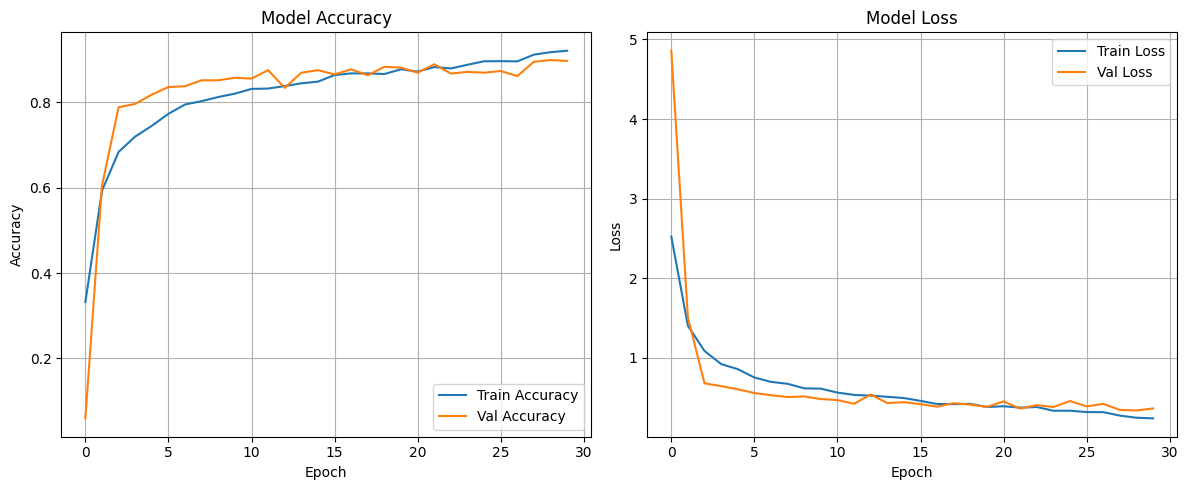

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step

Accuracy per class:
Hebrew Letter 0: 1.0000
Hebrew Letter 1: 0.7895
Hebrew Letter 2: 0.6842
Hebrew Letter 3: 0.9500
Hebrew Letter 4: 0.8421
Hebrew Letter 5: 0.7500
Hebrew Letter 6: 0.8421
Hebrew Letter 7: 0.9474
Hebrew Letter 8: 0.9500
Hebrew Letter 9: 0.8500
Hebrew Letter 10: 0.9474
Hebrew Letter 11: 0.7333
Hebrew Letter 12: 0.8500
Hebrew Letter 13: 1.0000
Hebrew Letter 14: 0.8750
Hebrew Letter 15: 0.9474
Hebrew Letter 16: 0.7500
Hebrew Letter 17: 0.8947
Hebrew Letter 18: 1.0000
Hebrew Letter 19: 0.8947
Hebrew Letter 20: 0.8125
Hebrew Letter 21: 0.8947
Hebrew Letter 22: 0.6471
Hebrew Letter 23: 0.8500
Hebrew Letter 24: 0.9524
Hebrew Letter 25: 0.8947
Hebrew Letter 26: 0.8889

Average accuracy: 0.8681


In [23]:
def train_with_fixed_augmentation():
    datagen = ImageDataGenerator(
        width_shift_range=0.02,        # Very minimal shift
        height_shift_range=0.02,       # Very minimal shift

        rotation_range=2,              # Very minimal rotation
        zoom_range=0.02,               # Very minimal zoom
        fill_mode='constant',          # Use constant for border filling
        cval=0.0                       # Fill with black (0.0)
    )

    # Build model
    model = build_cnn()

    # Setup callbacks for stable training
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        )
    ]

    # Train with a smaller batch size and lower epochs to start
    print("Training with fixed augmentation...")
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=16),
        validation_data=(X_val, y_val),
        epochs=30,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")

    # Return model and history for further analysis
    return model, history

# 4. Verify the data shapes and ranges before training
def check_data():
    print(f"X_train shape: {X_train.shape}, Range: [{X_train.min()}, {X_train.max()}]")
    print(f"X_val shape: {X_val.shape}, Range: [{X_val.min()}, {X_val.max()}]")
    print(f"X_test shape: {X_test.shape}, Range: [{X_test.min()}, {X_test.max()}]")

    # Check labels
    print(f"y_train shape: {y_train.shape}, Classes: {np.unique(y_train)}")
    print(f"Number of samples per class in training:")
    for i in range(27):
        count = np.sum(y_train == i)
        if count > 0:
            print(f"Class {i}: {count} samples")

# 5. Visualize some augmented images to verify augmentation
def visualize_augmentation():
    datagen = ImageDataGenerator(
        width_shift_range=0.02,
        height_shift_range=0.02,
        rotation_range=2,
        zoom_range=0.02,
        fill_mode='constant',
        cval=0.0
    )

    # Get a batch of images
    images = X_train[:5]  # Take first 5 images
    labels = y_train[:5]

    # Create a figure
    plt.figure(figsize=(10, 10))

    # Original images in first row
    for i in range(5):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].reshape(32, 32), cmap='gray')
        plt.title(f"Original: {labels[i]}")
        plt.axis('off')

    # Get augmented images
    aug_iter = datagen.flow(images, labels, batch_size=5)
    aug_images, aug_labels = next(aug_iter)

    # Augmented images in second row
    for i in range(5):
        plt.subplot(2, 5, i+6)
        plt.imshow(aug_images[i].reshape(32, 32), cmap='gray')
        plt.title(f"Augmented: {aug_labels[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 6. Run training and visualization
# First, check the data
check_data()

# Visualize augmentation to ensure it's reasonable
visualize_augmentation()

# Train the model with fixed augmentation
improved_model, improved_history = train_with_fixed_augmentation()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(improved_history.history['accuracy'], label='Train Accuracy')
plt.plot(improved_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(improved_history.history['loss'], label='Train Loss')
plt.plot(improved_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 7. Evaluate per-class performance
y_pred = np.argmax(improved_model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
acc_per_class = cm.diagonal() / cm.sum(axis=1)

print("\nAccuracy per class:")
for i, acc in enumerate(acc_per_class):
    print(f'Hebrew Letter {i}: {acc:.4f}')

print(f'\nAverage accuracy: {acc_per_class.mean():.4f}')

## 📉 8. Plot Training vs Validation Loss
Visualize how the training and validation loss evolve over epochs to assess overfitting.

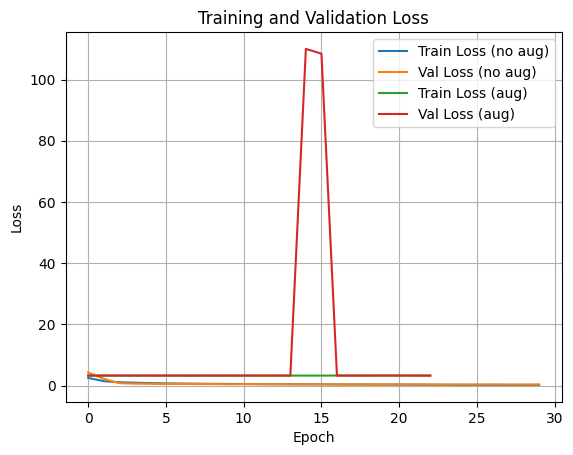

In [24]:
plt.plot(history.history['loss'], label='Train Loss (no aug)')
plt.plot(history.history['val_loss'], label='Val Loss (no aug)')
plt.plot(history_aug.history['loss'], label='Train Loss (aug)')
plt.plot(history_aug.history['val_loss'], label='Val Loss (aug)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.savefig('loss_curve.png'); plt.show()

## 📊 9. Evaluate on Test Set and Save Results

In [22]:
y_pred = np.argmax(model_aug.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
acc_per_class = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(acc_per_class):
    print(f'Letter {i}: {acc:.2f}')
print('Average accuracy:', acc_per_class.mean())
pd.DataFrame(cm).to_csv('confusion_matrix.csv', index=False)
with open('results.txt', 'w') as f:
    f.write('Letter    Accuracy\n')
    for i, acc in enumerate(acc_per_class):
        f.write(f'{i:<10}{acc:.4f}\n')
    f.write(f'\nAverage accuracy: {acc_per_class.mean():.4f}\n')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Letter 0: 0.00
Letter 1: 0.00
Letter 2: 0.00
Letter 3: 0.00
Letter 4: 0.00
Letter 5: 0.00
Letter 6: 0.00
Letter 7: 0.00
Letter 8: 0.00
Letter 9: 0.00
Letter 10: 0.00
Letter 11: 0.00
Letter 12: 0.00
Letter 13: 0.00
Letter 14: 0.00
Letter 15: 0.00
Letter 16: 0.00
Letter 17: 0.00
Letter 18: 0.00
Letter 19: 0.00
Letter 20: 0.00
Letter 21: 0.00
Letter 22: 0.00
Letter 23: 0.00
Letter 24: 1.00
Letter 25: 0.00
Letter 26: 0.00
Average accuracy: 0.037037037037037035
